# Taxinet Training

In this notebook, we will use the taxinet data we generated from the last exercise to train a neural network to estimate our current crosstrack error and heading error from a downsampled runway image.

First, lets import some of the python packages we will need. One of the packages we will be importing from in [tensorflow](https://www.tensorflow.org/). Tensorflow is a very popular machine learning package that implements a lot of the functions we need for training neural networks for us.

In [47]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD

## Get the data ready

We have generated a dataset 20,000 downsampled images using the code from the data generation notebook for you. The data is stored in the file called `taxi_ai4all_data.h5`. Run the following cell to read all of the training images into a numpy array called `X` and all of the labels into a numpy array called `y`.

In [48]:
f = h5py.File('taxi_ai4all_data.h5', 'r')
X = np.array(f['X']) #training images
y = np.array(f['y']) #labels

In order to check whether we are overfitting, we need to create a separate training and test set from our data. We will use the first 18,000 images as our training set and set aside the last 2000 images as the test set. Run the cell below to split the data:

In [49]:
# Split into train and test sets
X_train = X[:, :18000]
y_train = y[:, :18000]

X_test = X[:, 18000:]
y_test = y[:, 18000:]

## Choose your network architecture

Next, we will start selecting some of the **hyperparameters** of our network such as the number of layers and the sizes of the layers. The function below takes in a list of layer sizes and returns a tensorflow neural network model with the corresponding network:

In [50]:
def build_model(layer_sizes):
    model = Sequential()
    for i in range(1, len(layer_sizes) - 1):
        model.add(Dense(layer_sizes[i], activation = 'relu'))
    model.add(Dense(layer_sizes[-1]))
    return model

Fill in the cell below with your desired layer sizes:

In [92]:
layer_sizes = [128, 50, 50, 50, 50, 2] # Fill in your desired layer sizes! End has to be 2 as there's 2 outputs. Figure out what these arguments mean
model = build_model(layer_sizes)

## Set up your optimizer

We will use tensorflow "stochastic gradient descent" or SGD optimizer which work similarly to the gradient descent optimizer we learned about earlier! Fill in the cell below with your learning rate to create the optimizer:

In [93]:
learning_rate = 0.001 # Fill in your learning rate! Learning rates can be big
opt = SGD(learning_rate=learning_rate)

## Compile the model with your loss function

The following cell tells tensorflow to use our SGD optimizer with a mean squared error loss.

In [94]:
model.compile(optimizer=opt, loss='mse')

## Training time!

Run the cell below to train the model. The training will run for 100 epochs. You can think of an epoch like an iteration of gradient descent. At each epoch, tensorflow will print out our training and validation (test) loss. Before running the cell, discuss with your group what should happen to these values during training.

Once you are ready, run the cell to train your model!

In [104]:
model.fit(X_train.T, y_train.T, epochs=100, batch_size=64, validation_data=(X_test.T, y_test.T), verbose=1)

Epoch 1/100
282/282 [==============================] - 0s 1ms/step - loss: 0.2736 - val_loss: 0.6944
Epoch 2/100
282/282 [==============================] - 0s 1ms/step - loss: 0.2880 - val_loss: 0.3430
Epoch 3/100
282/282 [==============================] - 0s 992us/step - loss: 0.2743 - val_loss: 0.4161
Epoch 4/100
282/282 [==============================] - 0s 1ms/step - loss: 0.2833 - val_loss: 0.4679
Epoch 5/100
282/282 [==============================] - 0s 1ms/step - loss: 0.2759 - val_loss: 0.2637
Epoch 6/100
282/282 [==============================] - 0s 1ms/step - loss: 0.2827 - val_loss: 0.4719
Epoch 7/100
282/282 [==============================] - 0s 1ms/step - loss: 0.2785 - val_loss: 0.4605
Epoch 8/100
282/282 [==============================] - 0s 1ms/step - loss: 0.2716 - val_loss: 0.6977
Epoch 9/100
282/282 [==============================] - 0s 991us/step - loss: 0.2639 - val_loss: 0.3694
Epoch 10/100
282/282 [==============================] - 0s 997us/step - loss: 0.2729 - 

## Evaluation

Let's see how our training did! Run the cell below to get our model's predictions on the train and test sets.

In [107]:
y_train_pred = model.predict(X_train.T)
y_test_pred = model.predict(X_test.T)

First, let's check out our model evaluations on the first 10 images in our test set. Run the cell create a plot with this information. This might be a nice plot to include in your final presentation :).

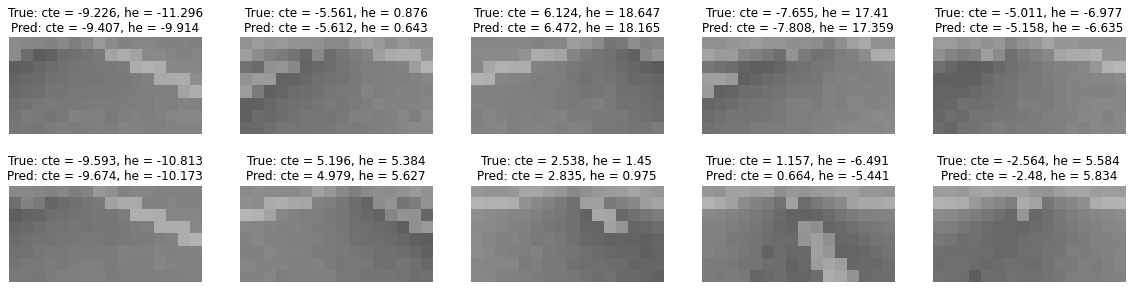

In [108]:
fig = plt.figure()

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    img = np.reshape(X_test[:, i], (8, 16))
    imgplot = plt.imshow(img, cmap='gray', clim=(0, 1))
    title_string = 'True: cte = ' + \
                    str(round(y_test[0, i], 3)) +  \
                    ', he = ' + \
                    str(round(y_test[1, i], 3)) + \
                    '\nPred: cte = ' + \
                    str(round(y_test_pred[i, 0], 3)) +  \
                    ', he = ' + \
                    str(round(y_test_pred[i, 1], 3))
    ax.set_title(title_string)
    plt.axis('off')

fig.set_figwidth(20)
fig.set_figheight(5)


How did it do on these examples? Looking at predictions on a few examples can give you an idea of whether your model is working, but in order to get the whole picture, we want to analyze some metrics across all of the examples in our data. To do that, let's compute the absolute value of the prediction errors for the train and test set:

In [109]:
errors_train = np.abs(y_train_pred.T - y_train)
errors_test = np.abs(y_test_pred.T - y_test)

But how can we analyze all 20,000 errors at once? A histogram is a good way to visualize the distribution of a set of data, so let's try to create one of those using matplotlib's `hist` function. Run the cell below to plot the errors on the training and test set. (Another plot this might be good for your final presentation :)).

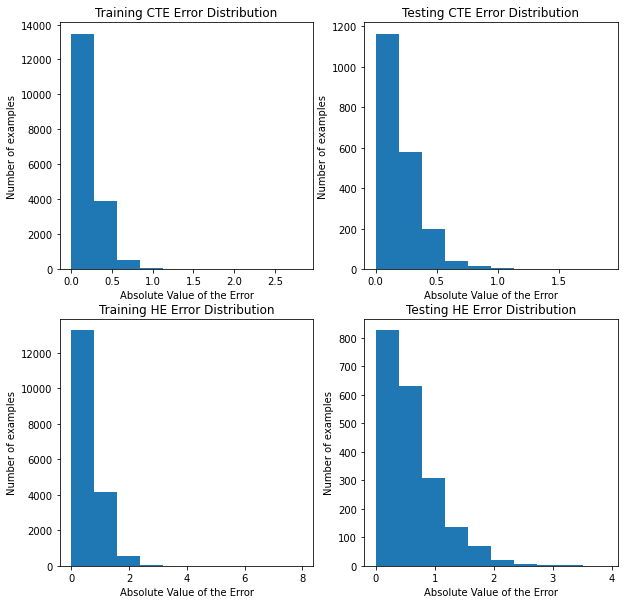

In [110]:
fig = plt.figure()

plt.subplot(221)
plt.hist(errors_train[0, :])
plt.xlabel('Absolute Value of the Error')
plt.ylabel('Number of examples')
plt.title('Training CTE Error Distribution')

plt.subplot(222)
plt.hist(errors_test[0, :])
plt.xlabel('Absolute Value of the Error')
plt.ylabel('Number of examples')
plt.title('Testing CTE Error Distribution')

plt.subplot(223)
plt.hist(errors_train[1, :])
plt.xlabel('Absolute Value of the Error')
plt.ylabel('Number of examples')
plt.title('Training HE Error Distribution')

plt.subplot(224)
plt.hist(errors_test[1, :])
plt.xlabel('Absolute Value of the Error')
plt.ylabel('Number of examples')
plt.title('Testing HE Error Distribution')

fig.set_figwidth(10)
fig.set_figheight(10)

plt.show()


What do you notice about the two distributions. Is it what you expect? Discuss with your group.

## Analyze the results and make changes

Now that you have trained a network and done some analysis, it's time to go back and try to make some changes to improve your model. Try tuning some of the **hyperparameters** to observe their affect on the training and the effectiveness of the final model. Some hyperparameters to try changing include:
- number of layers
- number of neurons in each layer
- learning rate
- number of epochs
- batch size

As you go back through the training cycle and test out your changes, discuss the following questions with your group. When we come back together, we will ask each group to share their findings.
1. How do the number of layers and the number of neurons in each layer seem to affect the training?
2. How does changing the learning rate affect the training?
3. Does increasing the number of epochs help? Could we decrease it?
4. Do the train and validation (test accuracy) seem to match each other closely? If so, why? If not, why not?

In order to effectively control the aircraft, you should try to get your mse below 1.0.

## Save the model for later!
Once you are satisfied with your model, run the following line to save the model to a file called `Taxinet.h5`. This will allow us to use it in the next notebook where we make it taxi down the runway!

In [100]:
model.save('Taxinet.h5')